# CLEAR: Clustering and Stock Impact-based News Recommendation System

## 시스템 데모 노트북

이 노트북은 CLEAR(Clustering and Stock Impact-based News Recommendation System) 시스템의 각 모듈을 단계별로 시연합니다. 네이버의 AiRs 아키텍처를 기반으로 하되, 개인화 대신 주가 영향에 중점을 둔 뉴스 추천 시스템입니다.

### 목차
1. 환경 설정 및 데이터 로드
2. 텍스트 전처리
3. 뉴스 벡터화
4. 뉴스 클러스터링
5. 주가 영향 분석
6. 뉴스 추천
7. 결과 시각화 및 평가

## 1. 환경 설정 및 데이터 로드

먼저 필요한 라이브러리를 가져오고 시스템 구성 요소를 초기화합니다.

In [1]:
# 필요한 라이브러리 가져오기
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
import matplotlib.font_manager as fm
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

# 경로 설정
sys.path.append('../src')

# 시각화 스타일 설정
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

### CLEAR 모듈 가져오기

이제 CLEAR 시스템의 각 모듈을 가져옵니다.

In [2]:
# CLEAR 모듈 가져오기
from src.data.text_preprocessor import TextPreprocessor
from src.models.news_vectorizer import NewsVectorizer
from src.models.news_clustering import NewsClustering
from src.models.stock_impact_analyzer import StockImpactAnalyzer
from src.models.news_recommender import NewsRecommender
from src.evaluation import CLEAREvaluator

### 데이터 로드

제공된 뉴스 및 주가 데이터를 로드합니다.

In [3]:
# 데이터 경로 설정
NEWS_DATA_PATH = 'data/news/yna_005930_all.csv'
STOCK_DATA_PATH = 'data/stock/stockprice_005930.csv'

# 뉴스 데이터 로드
news_df = pd.read_csv(NEWS_DATA_PATH)
print(f"로드된 뉴스 기사: {len(news_df)}개")
print("뉴스 데이터 구조:")
print(news_df.columns)
print("\n뉴스 데이터 샘플:")
display(news_df.head(3))

# 주가 데이터 로드
stock_df = pd.read_csv(STOCK_DATA_PATH)
print(f"\n로드된 주가 데이터: {len(stock_df)}개 행")
print("주가 데이터 구조:")
print(stock_df.columns)
print("\n주가 데이터 샘플:")
display(stock_df.head(3))

로드된 뉴스 기사: 32208개
뉴스 데이터 구조:
Index(['Title', 'Date', 'Press', 'Link', 'Body', 'Emotion', 'Num_comment',
       'AI Summary'],
      dtype='object')

뉴스 데이터 샘플:


,Title,Date,Press,Link,Body,Emotion,Num_comment,AI Summary
0,"세계 2위 휴대전화 시장 인도, 이제 중·고가 제품에 눈 돌린다",20190101 15:36,yna,https://www.yna.co.kr/view/AKR20190101051400077,"김영현기자\n구독\n""저가에서 고급 브랜드로 관심 옮겨…5년간 4배 성장 예상""\n...","{'GOOD': '0', 'SAD': '0', 'ANGRY': '0', 'NEXT'...",NaN,NaN
1,[부고] 홍현칠(삼성전자 서남아총괄)씨 부친상,20190101 14:53,yna,https://www.yna.co.kr/view/AKR20190101048900077,"김영현기자\n구독\n▲ 홍선기씨 별세, 홍현구·현칠(삼성전자 서남아총괄 부사장)·현...","{'GOOD': '0', 'SAD': '0', 'ANGRY': '0', 'NEXT'...",NaN,NaN
2,"SK그룹, CES서 신사업 기회 모색…경영진 총출동",20190101 09:00,yna,https://www.yna.co.kr/view/AKR20181231260700003,배영경기자\n구독\n(서울=연합뉴스) 배영경 기자 = SK이노베이션·SK텔레콤·SK...,"{'GOOD': '0', 'SAD': '0', 'ANGRY': '0', 'NEXT'...",NaN,NaN



로드된 주가 데이터: 1517개 행
주가 데이터 구조:
Index(['Date', 'Time', 'Start', 'High', 'Low', 'End', 'Volume'], dtype='object')

주가 데이터 샘플:


,Date,Time,Start,High,Low,End,Volume
0,20250305,0,55100,55400,54200,54300,6367338
1,20250304,0,53900,55000,53800,54500,18553933
2,20250228,0,55400,55700,54500,54500,28036698


### 데이터 전처리 및 준비

날짜 형식을 변환하고 데이터를 분석에 적합한 형태로 준비합니다.

In [4]:
# 뉴스 데이터 날짜 처리
def process_news_date(date_str):
    # 날짜 형식: "20250101 18:56"
    date_parts = date_str.split()
    date = date_parts[0]
    time = date_parts[1] if len(date_parts) > 1 else "00:00"
    
    year = int(date[:4])
    month = int(date[4:6])
    day = int(date[6:8])
    
    hour, minute = map(int, time.split(':'))
    
    return datetime(year, month, day, hour, minute)

# 주가 데이터 날짜 처리
# def process_stock_date(date_str, time_str):
#     # 날짜 형식: "20250305", 시간 형식: "09:00"
#     year = int(date_str[:4])
#     month = int(date_str[4:6])
#     day = int(date_str[6:8])
    
#     hour, minute = map(int, time_str.split(':'))
    
#     return datetime(year, month, day, hour, minute)

def process_stock_date(date_str, time_str=None):
    year = int(date_str[:4])
    month = int(date_str[4:6])
    day = int(date_str[6:8])

    if isinstance(time_str, str) and ':' in time_str:
        hour, minute = map(int, time_str.split(':'))
    else:
        hour, minute = 0, 0

    return datetime(year, month, day, hour, minute)

# 뉴스 데이터 날짜 변환
news_df['datetime'] = news_df['Date'].apply(process_news_date)
news_df['date'] = news_df['datetime'].dt.date

# 주가 데이터 날짜 변환
stock_df['datetime'] = stock_df.apply(lambda row: process_stock_date(str(row['Date']), row['Time']), axis=1)
stock_df['date'] = stock_df['datetime'].dt.date

# 주가 데이터 사전 준비
stock_data = {'005930': stock_df}

print("데이터 전처리 완료")
print(f"뉴스 데이터 날짜 범위: {news_df['date'].min()} ~ {news_df['date'].max()}")
print(f"주가 데이터 날짜 범위: {stock_df['date'].min()} ~ {stock_df['date'].max()}")

데이터 전처리 완료
뉴스 데이터 날짜 범위: 2019-01-01 ~ 2025-03-16
주가 데이터 날짜 범위: 2019-01-02 ~ 2025-03-05


## 2. 텍스트 전처리

뉴스 기사의 텍스트를 전처리합니다. 이 단계에서는 다음 작업을 수행합니다:
- 토큰화 (Mecab을 사용한 한국어 형태소 분석)
- 불용어 제거
- 특수 문자 및 숫자 처리
- 키워드 추출

In [5]:
# 텍스트 전처리기 초기화
text_preprocessor = TextPreprocessor(
    language='ko',
    use_mecab=True,
    remove_stopwords=True,
    min_token_length=2
)

# 전처리 예시 - 단일 텍스트
sample_text = news_df.iloc[0]['Body']
print("원본 텍스트 샘플:")
print(sample_text[:300], "...")

processed_text = text_preprocessor.preprocess_text(sample_text)
print("\n전처리된 텍스트:")
print(processed_text[:300], "...")

# 키워드 추출 예시
keywords = text_preprocessor.extract_keywords(sample_text, top_n=10)
print("\n추출된 키워드:")
print(keywords)

2025-03-27 16:26:58,413 - src.data.text_preprocessor - INFO - Initialized Mecab tokenizer
2025-03-27 16:26:58,543 - src.data.text_preprocessor - INFO - Initialized 399 stopwords
2025-03-27 16:26:58,543 - src.data.text_preprocessor - INFO - Initialized TextPreprocessor with language=ko, use_mecab=True


원본 텍스트 샘플:
김영현기자
구독
"저가에서 고급 브랜드로 관심 옮겨…5년간 4배 성장 예상"
이미지 확대
갤럭시 노트9으로 셀피 찍는 인도 시민들
(서울=연합뉴스) 삼성전자가 2018년 9월 11일(현지시간) 인도 방갈로르에 모바일 체험 스토어 '삼성 오페라 하우스'를 개관했다. 방문객들이 '갤럭시 노트9'의 S펜 블루투스 기능을 이용해 셀피를 촬영하고 있다. 2018.9.11 [삼성전자 제공]
(뉴델리=연합뉴스) 김영현 특파원 = 세계 2위의 휴대전화 판매 시장인 인도의 소비자가 이제 저가 제품을 뛰어넘어 중·고가 브랜드에 지갑을 연다는 분석이  ...

전처리된 텍스트:
김영현 구독 고급 브랜드 관심 옮겨 성장 이미지 확대 갤럭시 노트 셀피 인도 시민 서울 연합뉴스 삼성전자 현지 시간 인도 방갈로르 모바일 체험 스토어 삼성 오페라 하우스 개관 방문객 갤럭시 노트 블루투스 기능 이용 셀피 촬영 삼성전자 제공 뉴델리 연합뉴스 김영현 특파원 세계 휴대 전화 판매 인도 소비자 제품 뛰어넘 브랜드 지갑 연다는 나왔 인도 일간 코노 타임스 전문가 인용 천만 팔려 전년 성장 현지 스마트폰 성장 기록 신문 루피 이하 제품 위주 인도 스마트폰 소득 수준 향상 힘입 고급 제품 확대 조사 업체 카운터포인트 리서치 타룬 ...

추출된 키워드:
['인도', '브랜드', '휴대', '전화', '제품', '성장', '확대', '삼성전자', '갤럭시', '스마트폰']


### 전체 뉴스 데이터 전처리

이제 전체 뉴스 데이터셋에 전처리를 적용합니다.

In [6]:
# 전체 뉴스 데이터 전처리
print("전체 뉴스 데이터 전처리 중...")

# 제목 및 본문 전처리
preprocessed_df = text_preprocessor.preprocess_dataframe(
    news_df,
    title_col='Title',
    body_col='Body',
    summary_col='AI Summary',
    use_summary=True
)

# 키워드 추출
preprocessed_df = text_preprocessor.extract_keywords_from_df(
    preprocessed_df,
    text_col='processed_content',
    top_n=10
)

print("전처리 완료")
print(f"전처리된 기사: {len(preprocessed_df)}개")
print("\n전처리된 데이터 샘플:")
display(preprocessed_df[['Title', 'processed_title', 'keywords']].head(3))

2025-03-27 16:26:59,639 - src.data.text_preprocessor - INFO - Preprocessing 32208 articles


전체 뉴스 데이터 전처리 중...


2025-03-27 16:27:00,363 - src.data.text_preprocessor - INFO - Preprocessed Title column
2025-03-27 16:27:00,508 - src.data.text_preprocessor - INFO - Using AI Summary when available, falling back to Body
2025-03-27 16:27:16,084 - src.data.text_preprocessor - INFO - Preprocessing complete for 32208 articles
2025-03-27 16:27:16,085 - src.data.text_preprocessor - INFO - Extracting keywords from 32208 articles
2025-03-27 16:27:22,867 - src.data.text_preprocessor - INFO - Extracted keywords for 32208 articles


전처리 완료
전처리된 기사: 32208개

전처리된 데이터 샘플:


,Title,processed_title,keywords
0,"세계 2위 휴대전화 시장 인도, 이제 중·고가 제품에 눈 돌린다",세계 휴대 전화 인도 이제 제품 돌린다,"[인도, 브랜드, 휴대, 전화, 제품, 성장, 확대, 삼성전자, 갤럭시, 스마트폰]"
1,[부고] 홍현칠(삼성전자 서남아총괄)씨 부친상,부고 홍현칠 삼성전자 총괄 부친상,"[오전, 서울, 송고, 김영현, 구독, 홍선기, 별세, 홍현, 성전, 총괄]"
2,"SK그룹, CES서 신사업 기회 모색…경영진 총출동",신사업 기회 모색 경영진 총출동,"[사장, 부스, 텔레콤, 관계사, 글로벌, 전시, 공동, 예정, 이노베이션, 하이닉스]"


## 3. 뉴스 벡터화

전처리된 뉴스 기사를 벡터 표현으로 변환합니다. 이 단계에서는 다음 작업을 수행합니다:
- TF-IDF 벡터화 (기본 방법)
- 제목과 내용의 가중치 조정
- 차원 축소 (선택 사항)

### 벡터화 방법 설명

TF-IDF(Term Frequency-Inverse Document Frequency)는 문서 집합에서 단어의 중요도를 계산하는 방법입니다.
- TF(Term Frequency): 특정 단어가 문서에 등장하는 빈도
- IDF(Inverse Document Frequency): 전체 문서 집합에서 특정 단어를 포함하는 문서의 수에 반비례하는 값

수식:
- $TF(t, d) = \frac{\text{단어 t가 문서 d에 등장한 횟수}}{\text{문서 d의 총 단어 수}}$
- $IDF(t) = \log\frac{\text{전체 문서 수}}{\text{단어 t가 등장한 문서 수}}$
- $TFIDF(t, d) = TF(t, d) \times IDF(t)$

2025-03-27 16:27:22,878 - src.models.news_vectorizer - WARNING - GPU requested but not available, falling back to CPU
2025-03-27 16:27:22,878 - src.models.news_vectorizer - INFO - Initialized TF-IDF vectorizer with max_features=10000
2025-03-27 16:27:22,878 - src.models.news_vectorizer - INFO - Initialized NewsVectorizer with method=tfidf, max_features=10000
2025-03-27 16:27:22,879 - src.models.news_vectorizer - INFO - Vectorizing 32208 articles using tfidf


뉴스 기사 벡터화 중...


2025-03-27 16:27:23,440 - src.models.news_vectorizer - INFO - Combined processed_title and processed_content with title weight 2.0
2025-03-27 16:27:23,440 - src.models.news_vectorizer - INFO - Fitting tfidf vectorizer on 32208 documents
2025-03-27 16:27:28,736 - src.models.news_vectorizer - INFO - TF-IDF vectorizer fitted with vocabulary size: 10000
2025-03-27 16:27:30,687 - src.models.news_vectorizer - INFO - Saved tfidf vectorizer model to /Users/hwangchiung/CLEAR/models/vectorizers/tfidf_vectorizer.joblib
2025-03-27 16:27:30,688 - src.models.news_vectorizer - INFO - Transforming 32208 documents using tfidf
2025-03-27 16:27:33,431 - src.models.news_vectorizer - INFO - Transformed 32208 documents to shape (32208, 10000)
2025-03-27 16:27:33,432 - src.models.news_vectorizer - INFO - Reducing dimensions from 10000 to 100
2025-03-27 16:27:37,438 - src.models.news_vectorizer - INFO - Saved SVD model to /Users/hwangchiung/CLEAR/models/vectorizers/tfidf_svd_model.joblib
2025-03-27 16:27:37,4

벡터화 완료
벡터화된 기사: 32208개
벡터 차원: 100


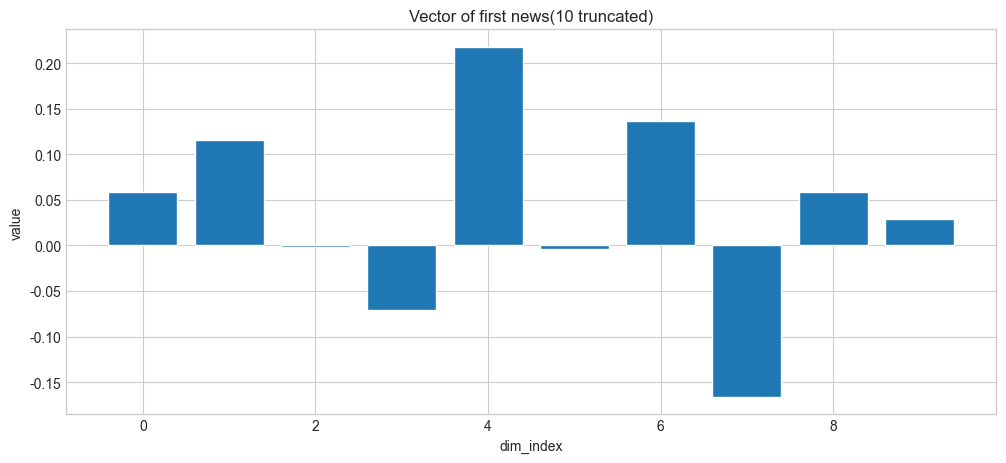

In [7]:
# 뉴스 벡터화기 초기화
news_vectorizer = NewsVectorizer(
    method='tfidf',
    max_features=10000,
    embedding_dim=300,
    use_gpu=True,
    title_weight=2.0
)

# 벡터화 수행
print("뉴스 기사 벡터화 중...")
vectorized_df = news_vectorizer.vectorize_articles(
    preprocessed_df,
    content_col='processed_content',
    title_col='processed_title',
    combine_title_content=True,
    reduce_dims=True,
    n_components=100
)

print("벡터화 완료")
print(f"벡터화된 기사: {len(vectorized_df)}개")

# 벡터 차원 확인
vector_sample = vectorized_df['vector'].iloc[0]
print(f"벡터 차원: {len(vector_sample)}")

# 벡터 시각화 (처음 10개 차원)
plt.figure(figsize=(12, 5))
plt.bar(range(10), vector_sample[:10])
plt.title('Vector of first news(10 truncated)')
plt.xlabel('dim_index')
plt.ylabel('value')
plt.show()

### 벡터 유사도 시각화

기사 간의 유사도를 시각화하여 벡터화의 효과를 확인합니다.

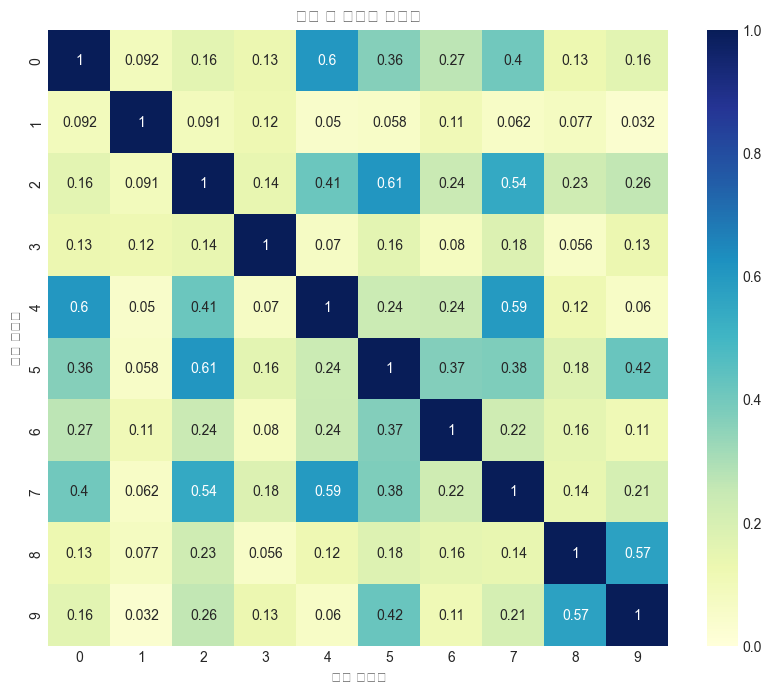

가장 유사한 기사 쌍: 2번과 5번 (유사도: 0.6061)

기사 2번 제목: SK그룹, CES서 신사업 기회 모색…경영진 총출동
기사 5번 제목: [2019 산업] 도전 산적한 반도체…다음 신성장 먹거리는


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# 샘플 기사 선택 (처음 10개)
sample_vectors = np.array(vectorized_df['vector'].iloc[:10].tolist())

# 코사인 유사도 계산
similarity_matrix = cosine_similarity(sample_vectors)

# 유사도 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='YlGnBu', vmin=0, vmax=1)
plt.title('기사 간 코사인 유사도')
plt.xlabel('기사 인덱스')
plt.ylabel('기사 인덱스')
plt.show()

# 가장 유사한 기사 쌍 찾기
np.fill_diagonal(similarity_matrix, 0)  # 자기 자신과의 유사도 제외
max_sim_idx = np.unravel_index(np.argmax(similarity_matrix), similarity_matrix.shape)
print(f"가장 유사한 기사 쌍: {max_sim_idx[0]}번과 {max_sim_idx[1]}번 (유사도: {similarity_matrix[max_sim_idx]:.4f})")

# 유사한 기사 제목 출력
print(f"\n기사 {max_sim_idx[0]}번 제목: {vectorized_df['Title'].iloc[max_sim_idx[0]]}, URL: {vectorized_df['Link'].iloc[max_sim_idx[0]]}")
print(f"기사 {max_sim_idx[1]}번 제목: {vectorized_df['Title'].iloc[max_sim_idx[1]]}, URL: {vectorized_df['Link'].iloc[max_sim_idx[1]]}")

## 4. 뉴스 클러스터링

벡터화된 뉴스 기사를 클러스터링하여 유사한 기사를 그룹화합니다. 이 단계에서는 다음 작업을 수행합니다:
- 계층적 응집 클러스터링 (HAC) 적용
- 클러스터 주제 생성
- 트렌드 클러스터 식별

### 클러스터링 알고리즘 설명

계층적 응집 클러스터링(HAC)은 네이버 AiRs 시스템에서도 사용하는 방법으로, 다음과 같은 단계로 진행됩니다:
1. 각 기사를 개별 클러스터로 시작
2. 가장 유사한 두 클러스터를 병합
3. 거리 임계값에 도달할 때까지 2단계 반복

거리 계산 공식 (코사인 거리):
- $distance(A, B) = 1 - \frac{A \cdot B}{||A|| \cdot ||B||}$

여기서 $A$와 $B$는 기사 벡터입니다.

2025-03-27 16:28:36,395 - src.models.news_clustering - INFO - Initialized NewsClustering with distance_threshold=0.7, min_cluster_size=2
2025-03-27 16:28:36,396 - src.models.news_clustering - INFO - Clustering 32208 articles


뉴스 기사 클러스터링 중...


2025-03-27 16:29:15,475 - src.models.news_clustering - INFO - Splitting 42 large clusters
2025-03-27 16:29:20,144 - src.models.news_clustering - INFO - Split large clusters, now have 1396 clusters
2025-03-27 16:29:26,652 - src.models.news_clustering - INFO - Clustering silhouette score: 0.2159
2025-03-27 16:29:26,652 - src.models.news_clustering - INFO - Created 1395 valid clusters
2025-03-27 16:29:26,666 - src.models.news_clustering - INFO - Saved cluster statistics to /Users/hwangchiung/CLEAR/models/clustering/cluster_stats_20250327_162926.csv
2025-03-27 16:29:37,440 - src.models.news_clustering - INFO - Saved cluster visualization to /Users/hwangchiung/CLEAR/models/clustering/cluster_visualization_20250327_162928.png


클러스터링 완료
생성된 클러스터 수: 1396

클러스터 크기 분포:


cluster_id
-1     239
 42      4
 43     54
 44     49
 45     31
 46      6
 47     11
 48     57
 49     19
 50      3
Name: count, dtype: int64

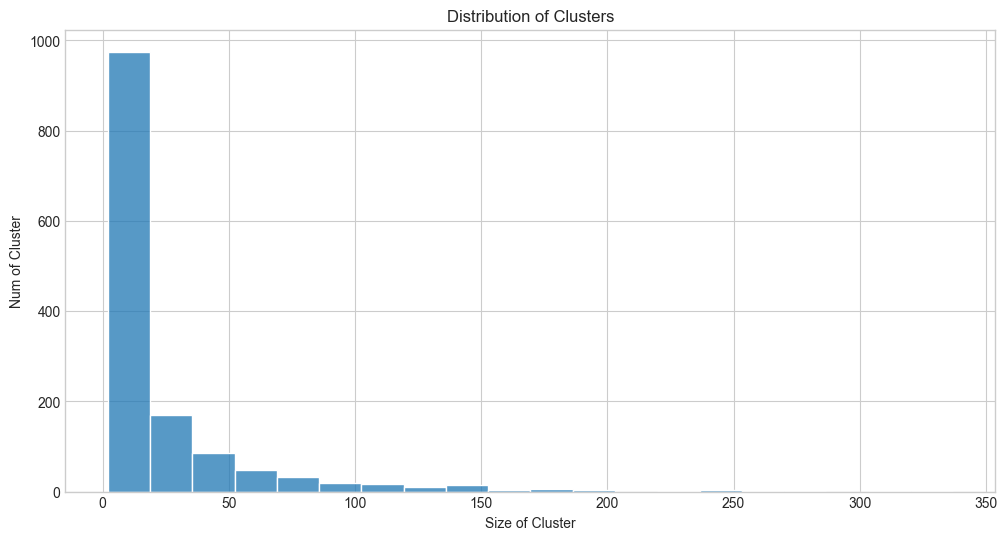

In [9]:
# 뉴스 클러스터링 초기화
news_clustering = NewsClustering(
    distance_threshold=0.7,  # 거리 임계값 (낮을수록 더 엄격한 클러스터링)
    min_cluster_size=2,      # 최소 클러스터 크기
    max_cluster_size=20,     # 최대 클러스터 크기
    linkage='average'        # 연결 방법 (평균 연결)
)

# 클러스터링 수행
print("뉴스 기사 클러스터링 중...")
clustered_df = news_clustering.cluster_articles(
    vectorized_df,
    vector_col='vector',
    title_col='Title',
    content_col='Body'
)

print("클러스터링 완료")
print(f"생성된 클러스터 수: {clustered_df['cluster_id'].nunique()}")

# 클러스터 크기 분포
cluster_sizes = clustered_df['cluster_id'].value_counts().sort_index()
print("\n클러스터 크기 분포:")
display(cluster_sizes.head(10))

# 클러스터 크기 히스토그램
plt.figure(figsize=(12, 6))
sns.histplot(cluster_sizes.values, bins=20)
plt.title('Distribution of Clusters')
plt.xlabel('Size of Cluster')
plt.ylabel('Num of Cluster')
plt.show()

### 클러스터 주제 및 내용 확인

생성된 클러스터의 주제와 포함된 기사를 확인합니다.

In [10]:
# 클러스터 주제 확인
cluster_topics = clustered_df.groupby('cluster_id')['cluster_topic'].first()
print("클러스터 주제 샘플:")
display(cluster_topics.head(5))

# 클러스터별 크기 확인
cluster_sizes = clustered_df['cluster_id'].value_counts()

# 특정 클러스터 기사 확인 (가장 큰 클러스터 예시)
sample_cluster_id = cluster_sizes.index[0]
sample_cluster = clustered_df[clustered_df['cluster_id'] == sample_cluster_id]

print(f"\n클러스터 {sample_cluster_id}번 (주제: {sample_cluster['cluster_topic'].iloc[0]})의 기사:")
display(sample_cluster[['Title', 'Date', 'Press']].head())

클러스터 주제 샘플:


cluster_id
-1                                 
 42    코로나19 시대…중국서 치열해지는 '중고급폰' 대결
 43           스마트폰 화웨이 화웨이, "화웨이 시장
 44                tv 글로벌 연속 1위 점유율
 45                인도 삼성, 인도서 1위 2위
Name: cluster_topic, dtype: object


클러스터 856번 (주제: 코스피 코스피, 매수에 만에 매도에)의 기사:


,Title,Date,Press
12,"새해 첫 거래일 코스피 2,010선 '털썩'…두달만의 최저(종합2보)",20190102 16:12,yna
31,"'애플 쇼크'에 코스피 2,000선 붕괴…2년1개월 만에 최저(종합3보)",20190103 17:32,yna
35,"'애플 쇼크'에 코스피 2,000선 붕괴…2년1개월 만에 최저(종합2보)",20190103 16:25,yna
58,"코스피 사흘 만에 상승…기관 매수에 2,010선 회복(종합2보)",20190104 16:15,yna
88,"이틀째 오른 코스피 2,030대 회복…코스닥도 1%대 상승(종합2보)",20190107 15:56,yna


### 트렌드 클러스터 식별

최근 24시간 내에 많은 기사가 포함된 클러스터를 트렌드 클러스터로 식별합니다.

In [ ]:
# 트렌드 클러스터 식별
trending_clusters = news_clustering.get_trending_clusters(
    clustered_df,
    timeframe_hours=24,
    min_articles=2
)

print(f"식별된 트렌드 클러스터: {len(trending_clusters)}개")

print("\n트렌드 클러스터 주제:")
for cluster_id in trending_clusters:
    topic = clustered_df.loc[clustered_df['cluster_id'] == cluster_id, 'cluster_topic'].iloc[0]
    count = (clustered_df['cluster_id'] == cluster_id).sum()
    print(f"클러스터 {cluster_id}번: {topic} (기사 {count}개)")

2025-03-27 16:32:10,548 - src.models.news_clustering - INFO - Identifying trending clusters in the last 24 hours
2025-03-27 16:32:11,547 - src.models.news_clustering - WARNING - No articles found within the last 24 hours


식별된 트렌드 클러스터: 0개

트렌드 클러스터 주제:


## 5. 주가 영향 분석

뉴스 기사가 주가에 미치는 영향을 분석합니다. 이 단계는 네이버 AiRs의 개인화 구성 요소를 대체하는 CLEAR 시스템의 핵심 부분입니다.

### 영향 분석 방법 설명

주가 영향 분석은 다음 단계로 진행됩니다:
1. 각 뉴스 기사에 대해 발행 시간 식별
2. 여러 시간 윈도우(즉시, 단기, 중기)에서 주가 변화 계산
3. 가격 및 거래량 변화를 기반으로 영향 점수 계산

영향 점수 계산 공식:
- $Impact_{price} = \frac{Price_{after} - Price_{before}}{Price_{before}} \times 100$
- $Impact_{volume} = \frac{Volume_{after} - Volume_{avg}}{Volume_{avg}} \times 100$
- $Impact_{total} = w_{price} \times Impact_{price} + w_{volume} \times Impact_{volume}$

최종 영향 점수는 -5에서 +5 사이의 척도로 정규화됩니다.

2025-03-27 16:22:38,543 - src.models.stock_impact_analyzer - WARNING - GPU requested but not available, falling back to CPU
2025-03-27 16:22:38,544 - src.models.stock_impact_analyzer - INFO - Initialized StockImpactAnalyzer with 3 time windows
2025-03-27 16:22:38,545 - src.models.stock_impact_analyzer - INFO - Analyzing impact for 32208 news articles


주가 영향 분석 중...


2025-03-27 16:22:40,583 - src.models.stock_impact_analyzer - INFO - Completed impact analysis for 32208 articles
2025-03-27 16:22:49,578 - src.models.stock_impact_analyzer - INFO - Saved impact results to /Users/hwangchiung/CLEAR/models/stock_impact/impact_results_20250327_162240.csv


영향 분석 완료
영향 점수가 계산된 기사: 32208개


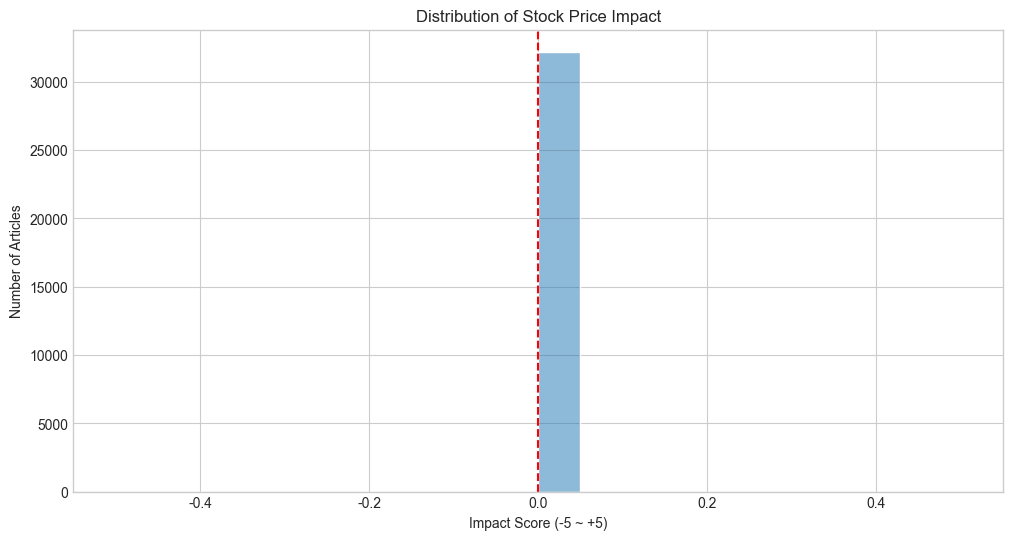


영향 점수 통계:


count    32208.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: impact_score, dtype: float64

In [23]:
# 주가 영향 분석기 초기화
impact_analyzer = StockImpactAnalyzer(
    time_windows=[
        {"name": "immediate", "hours": 1},
        {"name": "short_term", "hours": 24},
        {"name": "medium_term", "days": 3}
    ],
    impact_thresholds={
        "high": 0.02,    # 2% 가격 변동
        "medium": 0.01,  # 1% 가격 변동
        "low": 0.005     # 0.5% 가격 변동
    },
    use_gpu=True
)

# 영향 분석 수행
print("주가 영향 분석 중...")
impact_df = impact_analyzer.analyze_news_impact(
    clustered_df,
    stock_data
)

print("영향 분석 완료")
print(f"영향 점수가 계산된 기사: {len(impact_df.dropna(subset=['impact_score']))}개")

# 영향 점수 분포
plt.figure(figsize=(12, 6))
sns.histplot(impact_df['impact_score'].dropna(), bins=20, kde=True)
plt.title('Distribution of Stock Price Impact')
plt.xlabel('Impact Score (-5 ~ +5)')
plt.ylabel('Number of Articles')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

# 영향 점수 통계
impact_stats = impact_df['impact_score'].describe()
print("\n영향 점수 통계:")
display(impact_stats)

### 영향 예측 모델 훈련

과거 데이터를 기반으로 뉴스 기사의 주가 영향을 예측하는 모델을 훈련합니다.

2025-03-27 16:25:32,948 - src.models.stock_impact_analyzer - INFO - Training random_forest impact prediction model on 32208 articles


영향 예측 모델 훈련 중...


2025-03-27 16:25:33,947 - src.models.stock_impact_analyzer - INFO - Saved impact model to /Users/hwangchiung/CLEAR/models/stock_impact/impact_model_random_forest.joblib
2025-03-27 16:25:33,947 - src.models.stock_impact_analyzer - INFO - Trained random_forest impact model with 1372 features
2025-03-27 16:25:33,952 - src.models.stock_impact_analyzer - INFO - Predicting impact for 32208 articles
2025-03-27 16:25:34,804 - src.models.stock_impact_analyzer - INFO - Predicted impact for 32208 articles


예측 완료
예측된 영향 점수가 있는 기사: 32208개


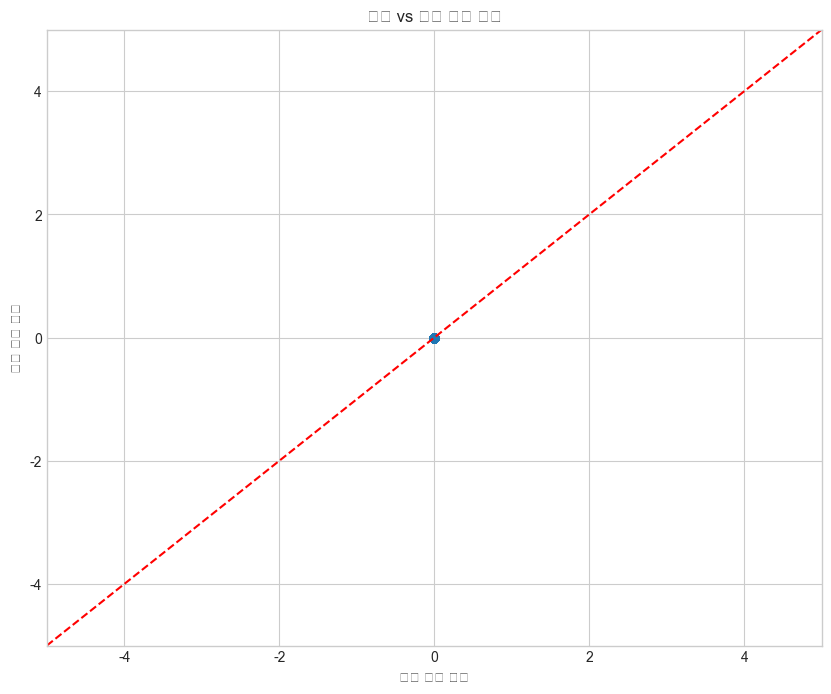


예측 성능 지표:
RMSE: 0.0000
MAE: 0.0000
R²: 1.0000


In [25]:
# 영향 예측 모델 훈련
print("영향 예측 모델 훈련 중...")
impact_analyzer.train_impact_model(
    impact_df,
    stock_data,
    model_type='random_forest'
)

# 예측 수행
impact_df = impact_analyzer.predict_impact(
    impact_df,
    # include_features=True
)

print("예측 완료")
print(f"예측된 영향 점수가 있는 기사: {len(impact_df.dropna(subset=['predicted_impact']))}개")

# 실제 vs 예측 영향 점수 비교
valid_impact_df = impact_df.dropna(subset=['impact_score', 'predicted_impact'])

plt.figure(figsize=(10, 8))
plt.scatter(valid_impact_df['impact_score'], valid_impact_df['predicted_impact'], alpha=0.6)
plt.plot([-5, 5], [-5, 5], 'r--')
plt.title('실제 vs 예측 영향 점수')
plt.xlabel('실제 영향 점수')
plt.ylabel('예측 영향 점수')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid(True)
plt.show()

# 예측 성능 지표
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true = valid_impact_df['impact_score']
y_pred = valid_impact_df['predicted_impact']

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n예측 성능 지표:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

### 주가 영향 시각화

뉴스 기사와 주가 변동 간의 관계를 시각화합니다.

In [26]:
# 주가 영향 시각화
ticker = '005930'  # 삼성전자
viz_path = impact_analyzer.visualize_impact(
    impact_df,
    stock_data,
    ticker,
    save_path=None  # 저장하지 않고 직접 표시
)

# 영향이 큰 상위 기사 확인
print("\n영향이 가장 큰 긍정적 기사 (상위 3개):")
display(impact_df.sort_values('impact_score', ascending=False)[['Title', 'Date', 'impact_score']].head(3))

print("\n영향이 가장 큰 부정적 기사 (상위 3개):")
display(impact_df.sort_values('impact_score')[['Title', 'Date', 'impact_score']].head(3))

TypeError: StockImpactAnalyzer.visualize_impact() got an unexpected keyword argument 'save_path'

## 6. 뉴스 추천

주가 영향 및 기타 요소를 기반으로 뉴스 기사를 추천합니다. 이 단계에서는 네이버 AiRs의 다중 요소 접근 방식을 유지하되, 개인화 대신 주가 영향에 중점을 둡니다.

### 추천 알고리즘 설명

CLEAR 추천 시스템은 다음 5가지 요소를 기반으로 점수를 계산합니다:
1. **주가 영향(SI)**: AiRs의 사회적 관심도를 대체하여 중요한 재무적 영향이 있는 기사 우선순위
2. **품질 평가(QE)**: 클러스터 크기 및 기타 지표를 기사 품질의 대리 지표로 사용
3. **콘텐츠 기반 필터링(CBF)**: 인기 있는 금융 기사와의 유사성 측정
4. **협업 필터링(CF)**: 기사 관계에 NPMI(정규화된 점별 상호 정보량) 사용
5. **최신**: 시기적절한 추천을 보장하기 위해 최근 기사 우선순위

최종 추천 점수 계산 공식:
- $Score = w_{impact} \times SI + w_{quality} \times QE + w_{content} \times CBF + w_{collaborative} \times CF + w_{recency} \times Latest$

In [27]:
# 뉴스 추천기 초기화
news_recommender = NewsRecommender(
    weights={
        'impact': 0.4,      # 주가 영향(SI)
        'quality': 0.2,     # 품질 평가(QE)
        'content': 0.2,     # 콘텐츠 기반 필터링(CBF)
        'collaborative': 0.1, # 협업 필터링(CF)
        'recency': 0.1      # 최신 뉴스 우선순위
    }
)

# 기사 추천 생성
print("뉴스 추천 생성 중...")
top_articles = news_recommender.recommend_articles(
    impact_df,
    top_n=10
)

print("추천 생성 완료")
print(f"추천된 기사: {len(top_articles)}개")

# 추천 기사 확인
print("\n추천 기사 목록:")
display(top_articles[['Title', 'Date', 'recommendation_score', 'impact_score', 'cluster_topic']].head(10))

2025-03-27 16:25:57,014 - src.models.news_recommender - INFO - Initialized NewsRecommender with weights: {'impact': 0.4, 'quality': 0.2, 'content': 0.2, 'collaborative': 0.1, 'recency': 0.1}
2025-03-27 16:25:57,014 - src.models.news_recommender - INFO - Generating recommendations from 32208 articles
2025-03-27 16:25:57,080 - src.models.news_recommender - INFO - Generated 10 recommendations
2025-03-27 16:25:57,090 - src.models.news_recommender - INFO - Saved recommendations to /Users/hwangchiung/CLEAR/models/recommender/recommendations_20250327_162557.csv


뉴스 추천 생성 중...
추천 생성 완료
추천된 기사: 10개

추천 기사 목록:


,Title,Date,recommendation_score,impact_score,cluster_topic
32139,[연합뉴스 이 시각 헤드라인] - 07:30,2025-03-11,0.496812,0.0,[연합뉴스 시각 헤드라인] 10:30 07:30
31882,[연합뉴스 이 시각 헤드라인] - 10:30,2025-02-21,0.496018,0.0,[연합뉴스 시각 헤드라인] 10:30 07:30
31638,[연합뉴스 이 시각 헤드라인] - 07:30,2025-02-05,0.495312,0.0,[연합뉴스 시각 헤드라인] 10:30 07:30
31571,[연합뉴스 이 시각 헤드라인] - 18:00,2025-02-04,0.495267,0.0,[연합뉴스 시각 헤드라인] 10:30 07:30
31589,[연합뉴스 이 시각 헤드라인] - 14:30,2025-02-04,0.495267,0.0,[연합뉴스 시각 헤드라인] 10:30 07:30
31532,[연합뉴스 이 시각 헤드라인] - 18:00,2025-02-03,0.495223,0.0,[연합뉴스 시각 헤드라인] 10:30 07:30
31493,[연합뉴스 이 시각 헤드라인] - 10:30,2025-01-31,0.495091,0.0,[연합뉴스 시각 헤드라인] 10:30 07:30
31509,[연합뉴스 이 시각 헤드라인] - 07:30,2025-01-31,0.495091,0.0,[연합뉴스 시각 헤드라인] 10:30 07:30
31482,[연합뉴스 이 시각 헤드라인] - 14:30,2025-01-31,0.495091,0.0,[연합뉴스 시각 헤드라인] 10:30 07:30
31462,[연합뉴스 이 시각 헤드라인] - 15:00,2025-01-30,0.495047,0.0,[연합뉴스 시각 헤드라인] 10:30 07:30


### 클러스터 기반 추천

클러스터 단위로 추천을 생성하여 다양한 주제의 뉴스를 제공합니다.

In [28]:
# 클러스터 추천 생성
top_clusters = news_recommender.recommend_clusters(
    impact_df,
    top_n=5,
    articles_per_cluster=3
)

print(f"추천된 클러스터: {len(top_clusters)}개")

# 각 클러스터의 추천 기사 확인
for cluster_id, cluster_df in top_clusters.items():
    cluster_topic = cluster_df['cluster_topic'].iloc[0]
    print(f"\n클러스터 {cluster_id}번 (주제: {cluster_topic})의 추천 기사:")
    display(cluster_df[['Title', 'Date', 'recommendation_score', 'impact_score']].head(3))

2025-03-27 16:26:02,063 - src.models.news_recommender - INFO - Generating cluster recommendations from 32208 articles
2025-03-27 16:26:02,670 - src.models.news_recommender - INFO - Generated recommendations for 5 clusters
2025-03-27 16:26:02,691 - src.models.news_recommender - INFO - Saved recommendations for 5 clusters


추천된 클러스터: 5개

클러스터 940번 (주제: [표] 코스피 지수선물·옵션 시세표(4일)-2 시세표(10일)-2)의 추천 기사:


KeyError: "['recommendation_score'] not in index"

### 트렌드 주제 추천

현재 트렌드인 주제를 추천합니다.

In [ ]:
# 트렌드 주제 추천
trending_topics = news_recommender.recommend_trending_topics(
    impact_df,
    top_n=5
)

print(f"추천된 트렌드 주제: {len(trending_topics)}개")
print("\n트렌드 주제 목록:")
for i, topic in enumerate(trending_topics, 1):
    print(f"{i}. {topic['topic']} (점수: {topic['score']:.2f})")

## 7. 결과 시각화 및 평가

시스템의 성능을 평가하고 결과를 시각화합니다.

In [ ]:
# 평가기 초기화
evaluator = CLEAREvaluator(results_dir="results/evaluation")

# 클러스터링 평가
print("클러스터링 평가 중...")
clustering_metrics = evaluator.evaluate_clustering(
    impact_df,
    vector_col='vector',
    cluster_col='cluster_id'
)

print("\n클러스터링 평가 지표:")
for metric, value in clustering_metrics.items():
    print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

# 영향 예측 평가
print("\n영향 예측 평가 중...")
impact_metrics = evaluator.evaluate_impact_prediction(
    impact_df,
    actual_col='impact_score',
    predicted_col='predicted_impact'
)

print("\n영향 예측 평가 지표:")
for metric, value in impact_metrics.items():
    print(f"{metric}: {value:.4f}")

# 추천 평가
print("\n추천 평가 중...")
recommendations = {
    'top_articles': top_articles,
    'top_clusters': top_clusters,
    'trending_topics': trending_topics
}
recommendation_metrics = evaluator.evaluate_recommendations(recommendations)

print("\n추천 평가 지표:")
for metric, value in recommendation_metrics.items():
    print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

### 종합 결과 시각화

시스템의 주요 결과를 종합적으로 시각화합니다.

In [ ]:
# 종합 결과 시각화
plt.figure(figsize=(15, 10))

# 1. 클러스터 크기 분포
plt.subplot(2, 2, 1)
sns.histplot(cluster_sizes.values, bins=20)
plt.title('클러스터 크기 분포')
plt.xlabel('클러스터 크기')
plt.ylabel('클러스터 수')

# 2. 영향 점수 분포
plt.subplot(2, 2, 2)
sns.histplot(impact_df['impact_score'].dropna(), bins=20, kde=True)
plt.title('주가 영향 점수 분포')
plt.xlabel('영향 점수 (-5 ~ +5)')
plt.ylabel('기사 수')
plt.axvline(x=0, color='r', linestyle='--')

# 3. 실제 vs 예측 영향 점수
plt.subplot(2, 2, 3)
plt.scatter(valid_impact_df['impact_score'], valid_impact_df['predicted_impact'], alpha=0.6)
plt.plot([-5, 5], [-5, 5], 'r--')
plt.title('실제 vs 예측 영향 점수')
plt.xlabel('실제 영향 점수')
plt.ylabel('예측 영향 점수')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid(True)

# 4. 추천 점수 분포
plt.subplot(2, 2, 4)
sns.histplot(top_articles['recommendation_score'], bins=20, kde=True)
plt.title('추천 점수 분포')
plt.xlabel('추천 점수')
plt.ylabel('기사 수')

plt.tight_layout()
plt.show()

## 결론

이 노트북에서는 CLEAR 시스템의 각 모듈을 단계별로 시연했습니다. CLEAR는 네이버의 AiRs 아키텍처를 기반으로 하되, 개인화 대신 주가 영향에 중점을 둔 뉴스 추천 시스템입니다.

주요 구성 요소:
1. **텍스트 전처리**: Mecab을 사용한 한국어 형태소 분석 및 불용어 제거
2. **뉴스 벡터화**: TF-IDF 및 기타 임베딩 방법을 사용한 벡터 표현 생성
3. **뉴스 클러스터링**: 계층적 응집 클러스터링을 사용한 유사 기사 그룹화
4. **주가 영향 분석**: 뉴스 기사가 주가에 미치는 영향 측정 및 예측
5. **뉴스 추천**: 주가 영향 및 기타 요소를 기반으로 한 다중 요소 추천

CLEAR 시스템은 AiRs의 핵심 메커니즘을 유지하면서 금융 도메인에 맞게 조정되어, 투자자와 금융 분석가에게 가치 있는 도구를 제공합니다.